In [1]:
using IntervalConstraintProgramming, TaylorModels, LazySets, Plots
using TaylorModels: Interval

Let $\mathcal{F}: (p(x_0, t), I)$ a Taylor Model flowpipe and $\mathcal{G}$ be a polyhedron that represents the guard.

The intersection between the guard and the flowpipe is:

$$
\mathcal{F} \cap \mathcal{G} = \{x : x = p(x_0, t) + y \wedge x_0 \in dom(\mathcal{F}) \wedge t \in [0, \delta] \wedge y \in rem(\mathcal{F}) \wedge x \in \mathcal{G} \}.
$$

To fix ideas, let $\mathcal{G}: a x \leq b$ be a hyperplanar guard, and ignore the time variable in the taylor model flowpipe.

### Example

Consider the TM flowpipe $F: x = 1 + x_0 t$, $x_0 \in [-1, 1]$, $t \in [0, 0.4]$. Compute a valid domain contraction for the intersection between $F$ and the guard $G: \{x \in \mathbb{R} : x \geq 1.2 \wedge x \leq 1.4\}$.

In [2]:
# taylor model flowpipe intersected with the guard
G1 = @constraint(1.0 + x0*t ≥ 1.2, [x0, t])
G2 = @constraint(1.0 + x0*t ≤ 1.4, [x0, t])

Separator:
  - variables: x0, t
  - expression: 1.0 + x0 * t ∈ [-∞, 1.40001]

In [3]:
S = G1 ∩ G2

Separator:
  - variables: x0, t
  - expression: (1.0 + x0 * t ∈ [1.19999, ∞]) ∩ (1.0 + x0 * t ∈ [-∞, 1.40001])

In [4]:
D = IntervalBox(-1..1, 0..0.4)

[-1, 1] × [0, 0.400001]

In [5]:
inner, outer = S(D)

([0.499999, 1] × [0, 0.400001], [-1, 1] × [0, 0.400001])

In [6]:
# other formulations
G1 = @constraint 1.0 + x0*t - 1.2 ≥ 0.0
G2 = @constraint 1.0 + x0*t - 1.4 ≤ 0.0
S = G1 ∩ G2
D = IntervalBox(-1..1, 0..0.4)
inner, outer = S(D)

([0.499999, 1] × [0, 0.400001], [-1, 1] × [0, 0.400001])

In [72]:
Interval(0.499999, 1) * Interval(0, 0.400001) + 1

[1, 1.40001]

In [57]:
outer

[-1, 1] × [0, 0.400001]

In [78]:
paving = pave(S, D, 0.1)

Paving:
- tolerance ϵ = 0.1
- inner approx. of length 7
- boundary approx. of length 8

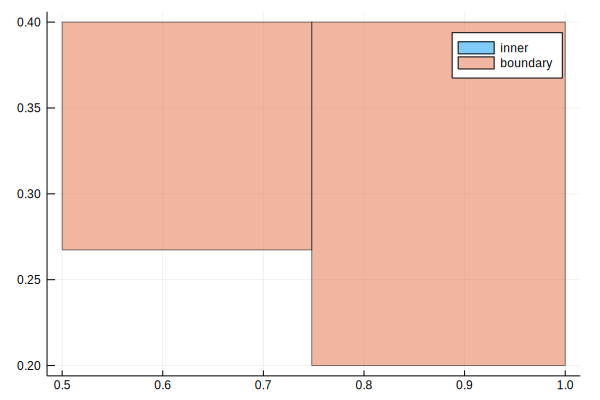

In [7]:
plot(pave(S, D, 0.5).inner, lab="inner")
plot!(pave(S, D, 0.5).boundary, lab="boundary")

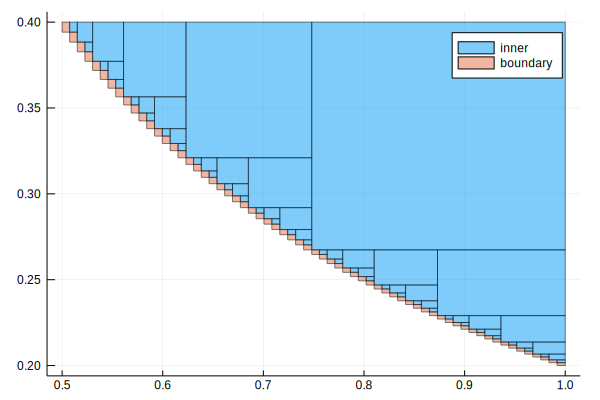

In [85]:
plot(pave(S, D, 0.01).inner, lab="inner")
plot!(pave(S, D, 0.01).boundary, lab="boundary")

---

In [108]:
# taylor model flowpipe intersected with the guard
f(x0, t) = 1.0 + x0*t
g(x0, t) = 1.0 + x0*t

G1 = @constraint(f ≥ 1.2, [x0, t])
G2 = @constraint(g ≤ 1.4, [x0, t])

Separator:
  - variables: x0, t
  - expression: 1g ∈ [-∞, 1.40001]

In [109]:
S = G1 ∩ G2

Separator:
  - variables: x0, t
  - expression: (1f ∈ [1.19999, ∞]) ∩ (1g ∈ [-∞, 1.40001])

In [ ]:
ord = 4
N = 2
dom = Interval(0.8, 1.2) × Interval(-0.2, 0.2)
x0 = [1.0, 0.0]
set_variables(Float64, "x", order=2ord, numvars=N)

# taylor model independent variables
x = [TaylorModelN(i, ord, IntervalBox(x0), dom) for i=1:N]

In [ ]:
# a taylor model flowpipe
F = [x[1]^2 * x[2]^2, -x[1] * x[2]^2]

Let's visualize the Taylor model flowpipe `F`:

In [ ]:
evaluate(F[1], [1.0, 2.0])

In [ ]:
using Distributions

D = domain(F[1])
U1 = Uniform(inf(D[1]), sup(D[1]))
U2 = Uniform(inf(D[2]), sup(D[2]))
Frange = Vector{IntervalBox{2, Float64}}()
npoints = 5e2
for i in 1:npoints
    u1, u2 = rand(U1), rand(U2)
    y1 = evaluate(F[1], [u1, u2])
    y2 = evaluate(F[2], [u1, u2])
    push!(Frange, y1 × y2)
end

In [ ]:
b = Ball2(zeros(2), 0.01)
Frange2 = [convert(Hyperrectangle, Fi) ⊕ b for Fi in Frange];

plot(Frange2)

In [ ]:
plot!(ConvexHullArray(Frange2), alpha=.4)

In [ ]:
F[1]

In [ ]:
S1a = @constraint(x > 0 , [x, y])

In [ ]:
const ICP = IntervalConstraintProgramming

S1a = ICP.@constraint(x1 - x2 == 0, [x1, x2, x10, x20])

In [ ]:
S1b = @constraint(y > 0 , [x, y])

    S1 = S1a ∩ S1b
paving = pave(S1, IntervalBox(-3..3, -3..3), 2.0, 0.5)

In [ ]:
# taylor model in one variable
function bounds_TM(func::Function, dom::Interval, ord::Int)
    x0 = Interval(mid(dom))
    x = TaylorModel1(ord, x0, dom)
    return evaluate(func(x), dom - x0)
end

# taylor model in N variables
function bounds_TM(func::Function, dom::IntervalBox{N}, ord) where {N}
    x0 = mid(dom)
    set_variables(Float64, "x", order=2ord, numvars=N)
    x = [TaylorModelN(i, ord, IntervalBox(x0), dom) for i=1:N]
    return evaluate(func(x...), dom - x0)
end

## Example using a TM flowpipe

In [48]:
using TaylorModels, IntervalArithmetic

# order of taylor series variables
ord = 4

# define the time variable
t = Taylor1(ord)

# number of spatial variables
N = 1

# define the spatial variable
set_variables(Float64, "x", order=2ord, numvars=N)
x = [TaylorN(Float64, i) for i in 1:N]

1-element Array{TaylorN{Float64},1}:
  1.0 x₁ + 𝒪(‖x‖⁹)

In [50]:
# define the polynomial passing the coefficients as an array of homogeneous polynomials
one_x = one(x[1])[0]
pol = Taylor1([one_x, x[1]])
rem = Interval(0.0, 0.0)
t0 = Interval(0.0, 0.0)
Δt = Interval(0.0, 0.4)

F = TaylorModel1(pol, rem, t0, Δt)

  1.0 + ( 1.0 x₁) t + [0, 0]

In [51]:
typeof(F)

TaylorModel1{TaylorN{Float64},Float64}

In [54]:
# guard
using LazySets: HalfSpace, HPolyhedron

In [56]:
G = HPolyhedron([HalfSpace([-1.0], -1.2),
                 HalfSpace([1.0], 1.4)])

HPolyhedron{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([-1.0], -1.2), HalfSpace{Float64,Array{Float64,1}}([1.0], 1.4)])

In [58]:
x1 = set_variables(Float64, ["x1"], order=2*3) x₀ = Interval(0.0, 0.0) Dx₁ = Interval(-1.0, 1.0) δ = 0.5 I = Interval(-δ, δ) x1 = set_variables(Float64, ["x1"], order=6) t = Taylor1(x1) p = t^2 + t + 1 f = TaylorModel1(p,I,x₀,Dx₁)

HPolyhedron{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([-1.0], -1.2), HalfSpace{Float64,Array{Float64,1}}([1.0], 1.4)])

In [61]:
x1 = set_variables(Float64, ["x1"], order=2*3)
x₀ = Interval(0.0, 0.0)
Dx₁ = Interval(-1.0, 1.0)
δ = 0.5
I = Interval(-δ, δ)
x1 = set_variables(Float64, ["x1"], order=6)
t = Taylor1(x1)

p  = t*x1[]

f = TaylorModel1(p,I,x₀,Dx₁)

MethodError: MethodError: no method matching TaylorModel1(::Array{Taylor1{TaylorN{Float64}},1}, ::Interval{Float64}, ::Interval{Float64}, ::Interval{Float64})
Closest candidates are:
  TaylorModel1(!Matched::Taylor1{T}, ::Interval{S}, ::Interval{S}, ::Interval{S}) where {T, S} at /Users/forets/.julia/dev/TaylorModels/src/constructors.jl:33
  TaylorModel1(!Matched::Integer, ::Any, ::Interval{T}) where T at /Users/forets/.julia/dev/TaylorModels/src/constructors.jl:36
  TaylorModel1(!Matched::Interval{T}, !Matched::Integer, ::Interval{T}, ::Interval{T}) where T at /Users/forets/.julia/dev/TaylorModels/src/constructors.jl:45
  ...

In [60]:
typeof(f)

TaylorModel1{TaylorN{Float64},Float64}

In [ ]:
S = Separator(-Inf..0.0, (x, y) -> evaluate(tm, IntervalBox(x, y)))

In [ ]:
S = Separator(-Inf..0.0, (x, y) -> Punder(x, y))
p = pave(S, IntervalBox(-2..2, 2), 0.01)

In [ ]:
# taylor model flowpipe intersected with the guard
f(x0, t) = 1.0 + x0*t
g(x0, t) = 1.0 + x0*t

G1 = @constraint(f ≥ 1.2, [x0, t])lop;[lo]
G2 = @constraint(g ≤ 1.4, [x0, t])